# Generate Phase-only Hologram (Kinoform Hologram)
 
- Reference
1. <i>L. B. Lesem, P. M. Hirsch, and J. A. Jordan, "The kinoform: a new wavefront reconstruction device", IBM Journal of Research and Development 13, 150–155 (1969).</i>
2. <i>Poon T C, and Liu J P (2014) "Introduction to Modern Digital Holography with MATLAB", (Cambridge University Press, New York).</i>
3. Internet Source: https://bora-game-develop-history.tistory.com/31

(2번 Reference에 관해서는 "VML-2022 > [Hologram] > 0.Book > (Book) 2014 Poon&Liu Introduction to Modern Digital Holography With Matlab.pdf > 7.2 "The kinoform hologram" 참고)

<br/>

#### <b>Kinoform Hologram</b>
높은 diffraction efficiency를 달성하기 위해 kinoform hologram이 제안되었다.
</br>
일반적으로 hologram은 다음과 같은 복소수 형태를 갖는다: $H(x, y)=a(x, y)e^{-j\phi(x, y)}$.
</br>
가장 중요한 점은 <u>에너지를 넓은 스펙트럼으로 확산시키기 위해 일반적으로 물체 패턴(object pattern)에 무작위 위상 마스크(random-phase mask)가 부착된다는 점이다.</u> 에너지 확산이 균일하면, Amplitude $a(x, y)$는 상대적으로 중요하지 않으며 무시할 수 있다. 따라서 우리는 오직 위상 $\phi(x, y)$만 추출하여 gray-tone pattern을 생성하면 된다. computer-generated holography에서 <u>kinoform holograms은 물체의 계산된 복소수 필드에서 위상 정보를 단순히 추출하고, 이를 phase-only SLM에 표시함으로써 쉽게 생성할 수 있다.</u>


In [9]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
cm, mm, um, nm = 1e-2, 1e-3, 1e-6, 1e-9

In [10]:
def pad_image(field, target_shape, padval=0, mode='constant'):
    """
        Pads a 2D complex field up to target_shape in size
        Padding is done such that when used with crop_image(), odd and even dimensions are handled correctly to properly undo the padding.

        field:          the field to be padded. May have as many leading dimensions as necessary (e.g., batch or channel dimensions)
        target_shape:   the 2D target output dimensions. If any dimensions are smaller than field, no padding is applied
        padval:         the real number value to pad by (default: 0)
        mode:           padding mode for numpy or torch
    """
    size_diff = np.array(target_shape) - np.array(field.shape[-2:])
    odd_dim = np.array(field.shape[-2:]) % 2

    # pad the dimensions that need to increase in size
    if (size_diff > 0).any():
        pad_total = np.maximum(size_diff, 0)
        pad_front = (pad_total + odd_dim) // 2
        pad_end = (pad_total + 1 - odd_dim) // 2

        leading_dims = field.ndim - 2  # only pad the last two dims
        if leading_dims > 0:
            pad_front = np.concatenate(([0] * leading_dims, pad_front))
            pad_end = np.concatenate(([0] * leading_dims, pad_end))
        return np.pad(field, tuple(zip(pad_front, pad_end)), mode, constant_values=padval)

    else:
        return field


In [11]:

def crop_image(field, target_shape):
    """
        Crops a 2D field, see pad_image() for detail
        No cropping is done if target_shape is already smaller than field
    """
    if target_shape is None:
        return field

    size_diff = np.array(field.shape[-2:]) - np.array(target_shape)
    odd_dim = np.array(field.shape[-2:]) % 2

    # crop dimensions that need to decrease in size
    if (size_diff > 0).any():
        crop_total = np.maximum(size_diff, 0)
        crop_front = (crop_total + 1 - odd_dim) // 2
        crop_end = (crop_total + odd_dim) // 2

        crop_slices = [slice(int(f), int(-e) if e else None) for f, e in zip(crop_front, crop_end)]
        return field[(..., *crop_slices)]
    else:
        return field

# 1. Make aperture at image plane (z=0)

$z_0$ 위치에서 Source plane (aperture) 생성. 이때, 단순한 binary 함수가 아닌, 다음의 수식을 통해 aperture를 생성한다.

$g(x, y;z_0)=\exp^{[-(\frac{\sqrt{x^2+y^2}}{D/2})^{50}]}$.

Source plane에서 $x$축, $y$축에 대한 표본화 간격 및 표본화 개수는 각각 10㎛, 1000을 따르며, aperture의 크기 $D=1$㎜로 설정한다.

- sampling interval: 10㎛
- the # of sample points: 1000
- source plane size: 10㎛ * 1000 = 10㎜
- aperture size: 1㎜


In [12]:
def source_field(image_size, aperture_size, sampling_interval, num_samples):

    # Grid Coordinate
    x_point = np.linspace(-image_size/2, image_size/2 - sampling_interval, num=num_samples)
    y_point = np.linspace(-image_size/2, image_size/2 - sampling_interval, num=num_samples)
    grid_x, grid_y = np.meshgrid(x_point, y_point)

    # Aperture
    aperture = np.sqrt((grid_x ** 2) + (grid_y ** 2)) / (aperture_size / 2)
    aperture = np.exp(-np.power(aperture, 50))
    return aperture

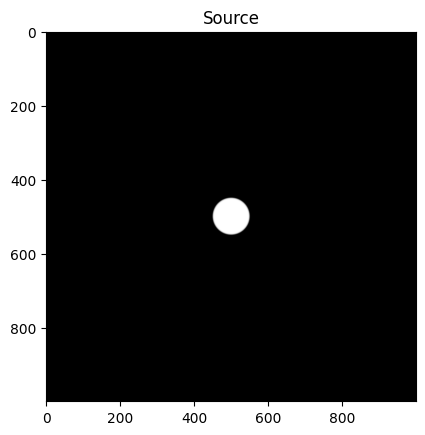

In [13]:
num_samples = 1000
sampling_interval = 10 * um
image_size = num_samples * sampling_interval
aperture_size = 1 * mm

# Make aperture at image plane (z=0)
source = source_field(image_size, aperture_size, sampling_interval, num_samples)

plt.imshow(source, cmap="gray")
plt.title("Source")
plt.show()

# 2. Band-limited Angular Spectrum Method (BL-ASM)

Band-Limited Angular Spectrum Method를 통해 $z_0$에 위치한 source를 $d$만큼 떨어진 거리의 destination field로 전파하는 방법은 다음과 같다.

$g[m, n; z] = FFT^{-1}[FFT[g[m, n; z_0]] \times H_{BLAS}[p, q; d]]$

1. $z_0$에 위치한 Image domain의 source plane을 Fourier Transform 한다.
2. Fourier domain에서 source plane을 $d$만큼 전파할 Transfer function (kernel)을 계산한다.
3. 1의 결과와 2의 결과를 곱한다. (Convolution in image domain)
4. 3의 결과에 inverse Fourier Transform 연산을 수행한다.


이때, Fourier domain에서의 transfer function $H$는 다음과 같이 계산할 수 있다.

$H_{BLAS}[p, q; d] = \begin{cases} \exp[i2\pi d(\lambda^{-2}-u_p^2-v_q^2)] rect(\frac{u_p}{2u_{BL}})rect(\frac{v_q}{2v_{BL}}) &\text{if } u_p^2+v_q^2\le\lambda^{-2}\\ 0 & \text{otherwise}  \end{cases}$



In [14]:
def propagation_blasm(u_in, feature_size, wave_length, z, sampling=1, linear_conv=True):
    """
        Propagates the input field using the angular spectrum method

        Inputs
        ------
        u_in:           input complex numpy array 
        feature_size:   (height, width) of individual holographic features in m
        wavelength:     wavelength in m
        z:              propagation distance
        sampling:       extended band-limited ASM, default 1
        linear_conv:    if True, pad the input to obtain a linear convolution, default True

        Output
        ------
        tensor of size (height, width)
    """

    # preprocess with (zero-)padding for linear convolution
    if linear_conv:
        input_resolution = u_in.shape[-2:]
        conv_size = [i * 2 for i in input_resolution]
        u_in = pad_image(u_in, conv_size, padval=0)

    field_resolution = u_in.shape[-2:]                          # Resolution of input field
    num_y, num_x = field_resolution[-2], field_resolution[-1]   # Number of pixels
    dy, dx = feature_size                                       # Sampling interval
    y, x = (dy * float(num_y), dx * float(num_x))               # Size of the input / slm field

    # frequency coordinates sampling
    fy = np.linspace(-1 / (2 * dy) + 0.5 / (2 * y), 1 / (2 * dy) - 0.5 / (2 * y), num_y)
    fx = np.linspace(-1 / (2 * dx) + 0.5 / (2 * x), 1 / (2 * dx) - 0.5 / (2 * x), num_x)
    fxx, fyy = np.meshgrid(fx, fy)

    # calculate transfer function (ASM)
    kernel = np.exp(1j * 2 * np.pi * z * np.sqrt(1 / wave_length**2 - (fxx**2 + fyy**2)))

    # calculate band-limited transfer function (BL-ASM)
    dv, du = 1 / (num_y * dy), 1 / (num_x * dx)
    bly = 1 / (wave_length * np.sqrt((2 * z * dv)**2 + 1))
    blx = 1 / (wave_length * np.sqrt((2 * z * du)**2 + 1))
    bl_filter = (np.abs(fxx) < blx) & (np.abs(fyy) < bly)
    bl_kernel = bl_filter * kernel

    # propagate source (aperture) to destination field
    u_out = fft.fftshift(fft.fftn(fft.fftshift(u_in), axes=(-2, -1)))     
    u_out = bl_kernel * u_out                                             
    u_out = fft.fftshift(fft.ifftn(fft.fftshift(u_out), axes=(-2, -1)))   
    
    if linear_conv:
        u_out = crop_image(u_out, input_resolution)

    return u_out

# 3. Make Full Complex Hologram
앞서 정의한 Propagation method를 통해 $d$만큼 떨어진 위치에서 complex hologram을 계산한다.

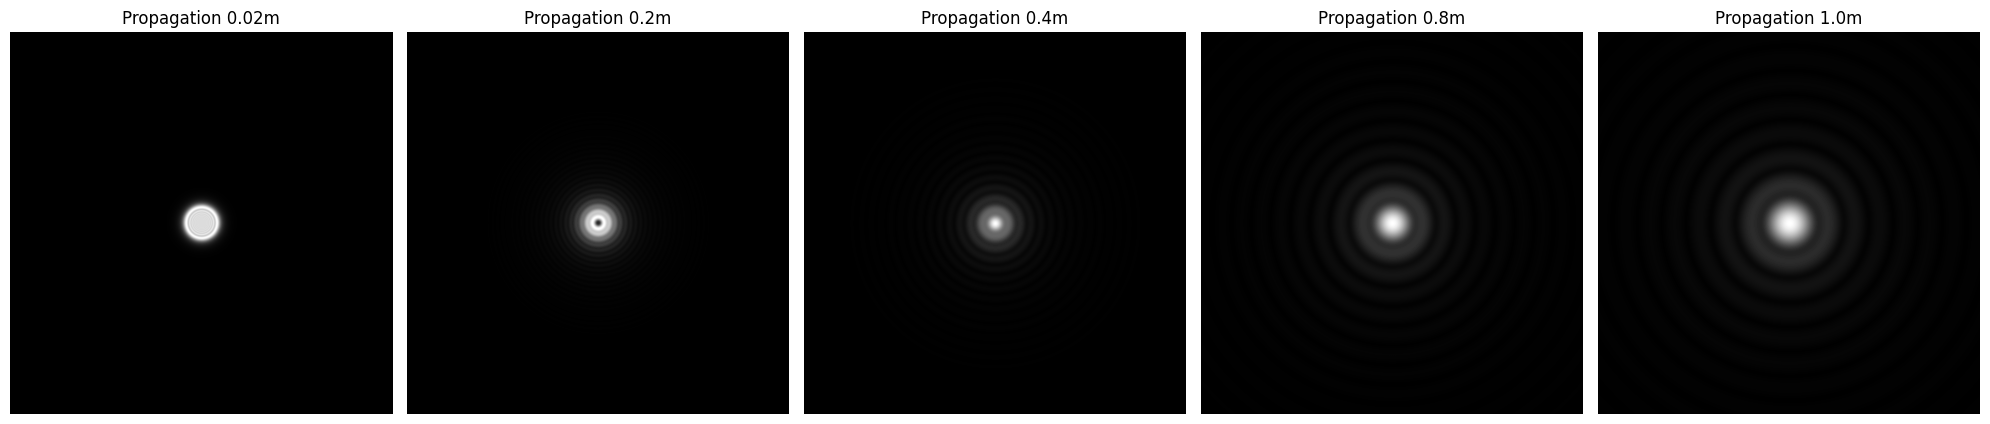

In [16]:
# fixed
source = source * np.exp(1j * np.zeros_like(source))
feature_size = (10 * um, 10 * um)

# experiment
wave_length = 633 * nm       
prop_dist = [2 * cm, 20 * cm, 40 * cm, 80 * cm, 100 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

image_to_slm = []       # The list of full-complex hologram
for z in prop_dist:
    image_to_slm.append(
        propagation_blasm(source, feature_size, wave_length, z)
    )

plt.figure(figsize=(20, 20))
for i, hologram in enumerate(image_to_slm):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(np.abs(hologram), cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 4. Kinoform Hologram

In [17]:
def kinoform(u_in, feature_size, wave_length, z, linear_conv=True, seed=7777):
    np.random.seed(seed)

    # Add a random phase to the image
    num_y, num_x = u_in.shape[-2], u_in.shape[-1]
    random_mask = np.random.rand(num_y, num_x)
    u_in = u_in * np.exp(1j * 2 * np.pi * random_mask)

    # Propagate to hologram plane
    u_out = propagation_blasm(u_in, feature_size, wave_length, z, sampling=1, linear_conv=linear_conv)

    # Extract Phase-only Hologram
    phase = np.angle(u_out)
    return phase

In [20]:
def kinoform_long_long(u_in, feature_size, wave_length, linear_conv=True, seed=7777):
    np.random.seed(seed)

    # Add a random phase to the image
    num_y, num_x = u_in.shape[-2], u_in.shape[-1]
    random_mask = np.random.rand(num_y, num_x)
    u_in = u_in * np.exp(1j * 2 * np.pi * random_mask)

    # Propagate to hologram plane
    u_out = propagation_blasm(u_in, feature_size, wave_length, 1.0, sampling=1, linear_conv=linear_conv)
    u_out = propagation_blasm(u_out, feature_size, wave_length, -0.98, sampling=1, linear_conv=linear_conv)

    # Extract Phase-only Hologram
    phase = np.angle(u_out)
    return phase

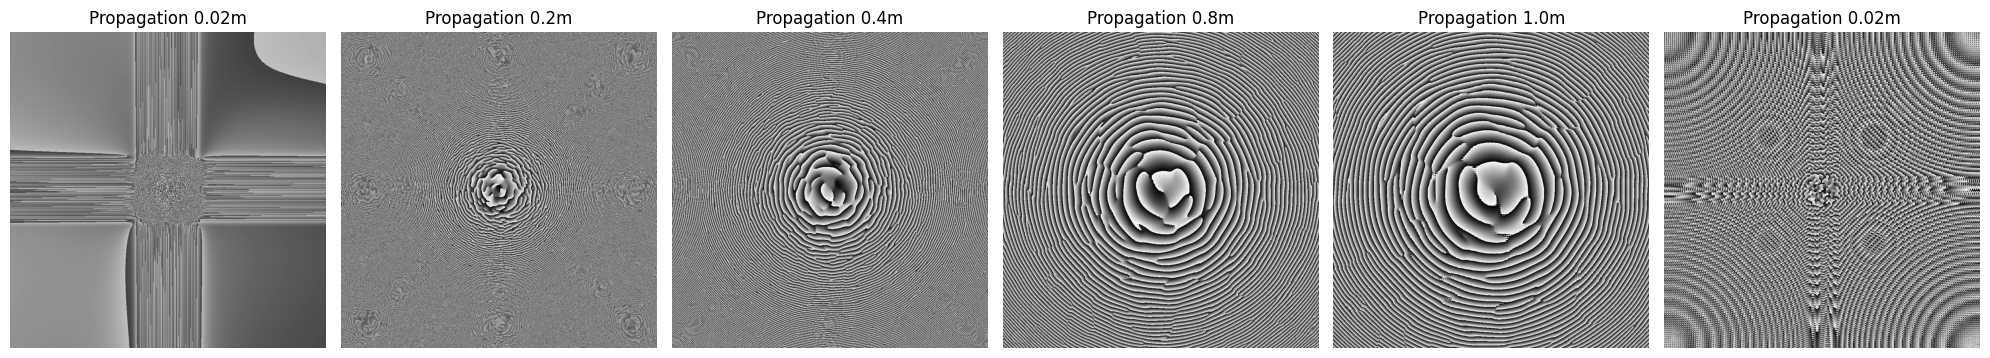

In [22]:
# Make aperture at image plane (z=0)
num_samples = 1000
sampling_interval = 10 * um
image_size = num_samples * sampling_interval
aperture_size = 1 * mm
source = source_field(image_size, aperture_size, sampling_interval, num_samples)

# fixed
feature_size = (sampling_interval, sampling_interval)

# experiment
wave_length = 633 * nm       
prop_dist = [2 * cm, 20 * cm, 40 * cm, 80 * cm, 100 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

# Generate Phase-only hologram with kinoform
kinoform_pohs = []       
for z in prop_dist:
    kinoform_pohs.append(
        kinoform(source, feature_size, wave_length, z)
    )
kinoform_pohs.append(
    kinoform_long_long(source, feature_size, wave_length)
)    
prop_dist.append(0.02)
visualization_title.append(f'Propagation {0.02}m')

plt.figure(figsize=(20, 20))
for i, kinoform_poh in enumerate(kinoform_pohs):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(kinoform_poh, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

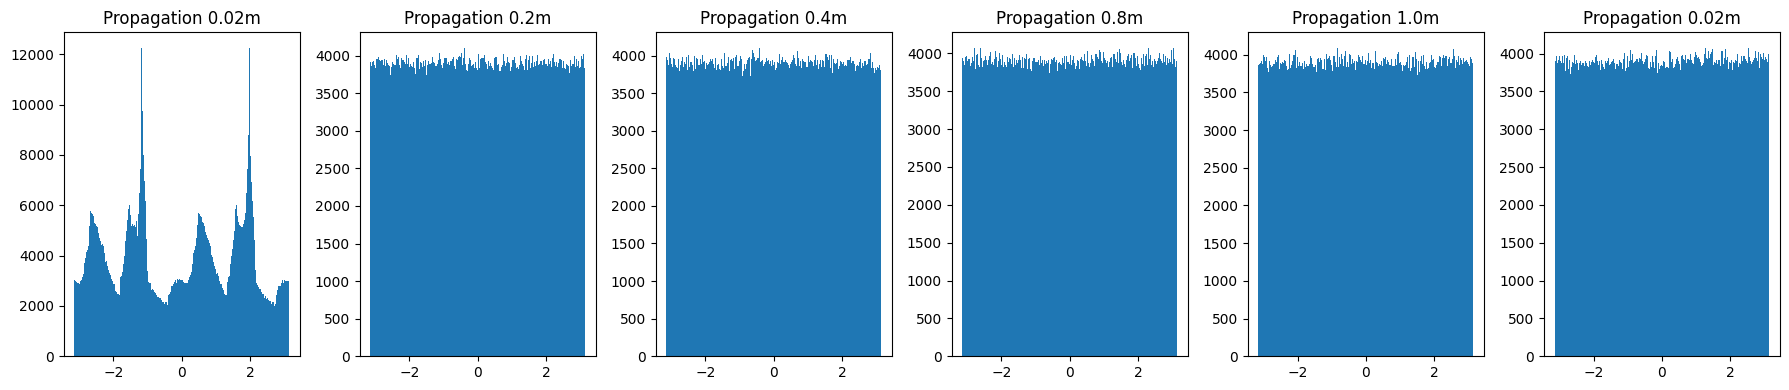

In [23]:
# Visualize the phase distribution of kinoform hologram
plt.figure(figsize=(18, 4))
for i, kinoform_poh in enumerate(kinoform_pohs):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.hist(kinoform_poh.flatten(), bins=256)
    plt.title(visualization_title[i])
plt.tight_layout()
plt.show()

# 5. Reconstruction

### 5-1. Visualize Numerical Reconstruction of Full-complex Hologram

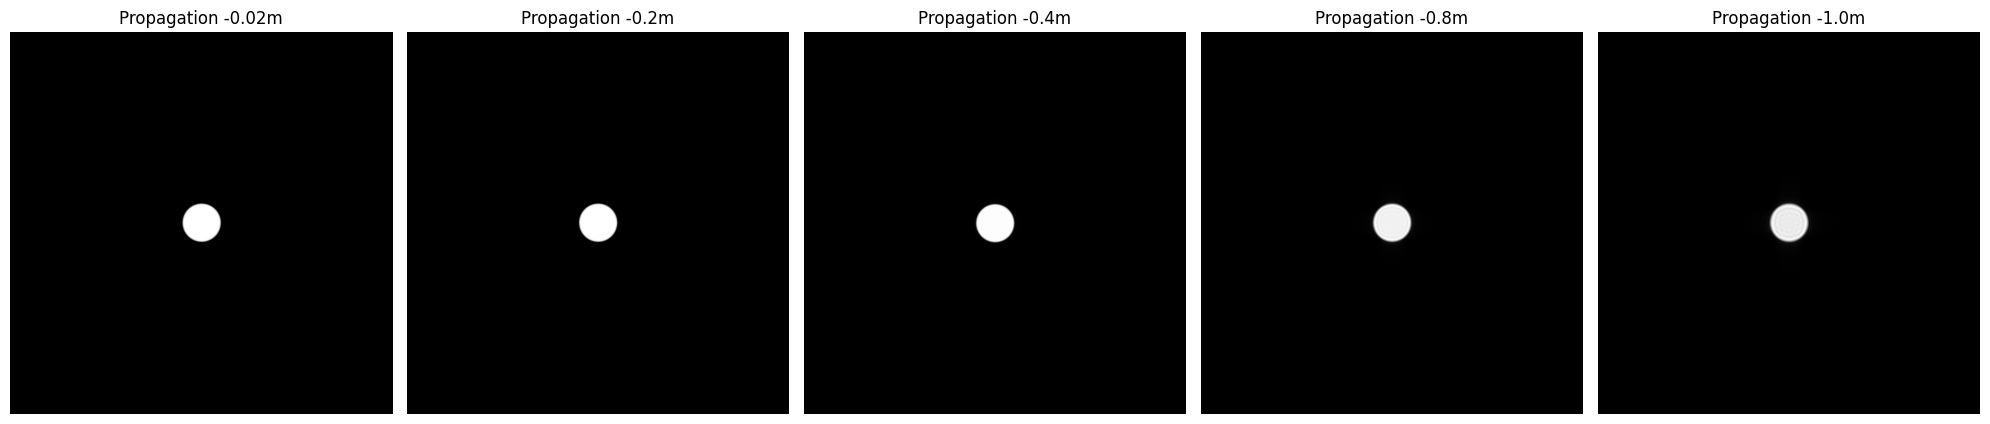

In [ ]:
visualization_title = [f'Propagation -{z}m' for z in prop_dist]

slm_to_image_1 = []
for z, hologram in zip(prop_dist, image_to_slm):
    recon = propagation_blasm(hologram, feature_size, wave_length, -z)
    
    recon = np.abs(recon)
    recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    slm_to_image_1.append(recon)

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image_1):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

### 5-2. Visualize Numerical Reconstruction of Kinoform Hologram

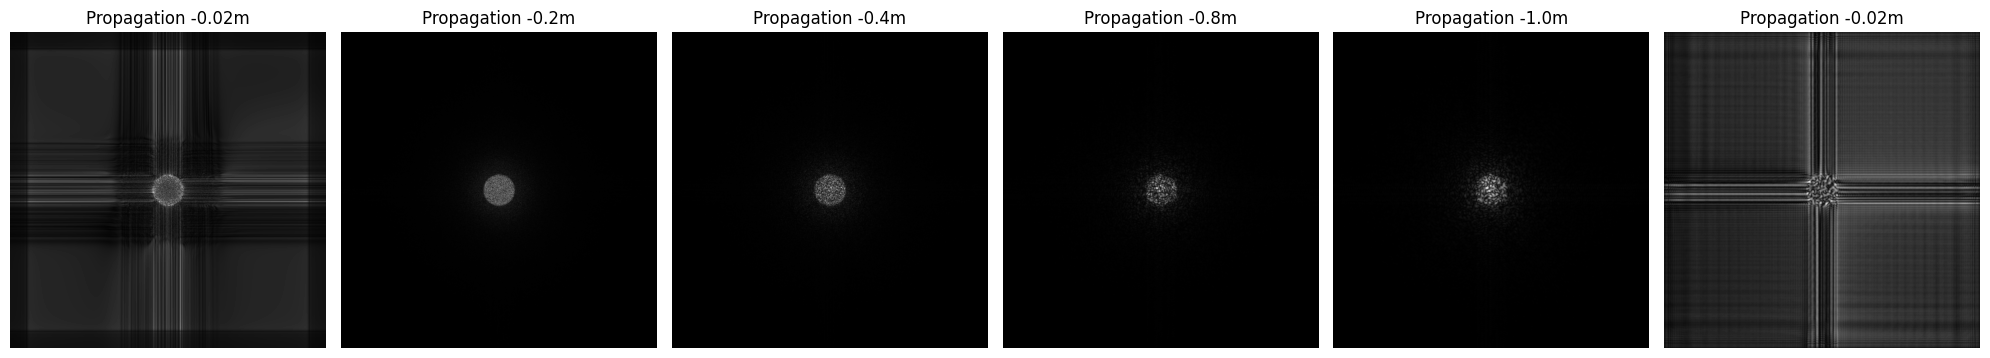

In [29]:
visualization_title = [f'Propagation -{z}m' for z in prop_dist]

slm_to_image_2 = []
for i, (z, kinoform_poh) in enumerate(zip(prop_dist, kinoform_pohs)):
    if i == len(prop_dist) - 1:
        recon = propagation_blasm(np.exp(1j * kinoform_poh), feature_size, wave_length, -1.0)
        recon = propagation_blasm(recon, feature_size, wave_length, 0.98)
    else:
        recon = propagation_blasm(np.exp(1j * kinoform_poh), feature_size, wave_length, -z)
    
    recon = np.abs(recon)
    recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    slm_to_image_2.append(recon)


plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image_2):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

# 6. Objective Quality Metrics


In [ ]:
def peak_signal_noise_ratio(target, output):
    mse = np.mean((target - output) ** 2)
    psnr = 20 * np.log10(1.0 / np.sqrt(mse))
    return psnr

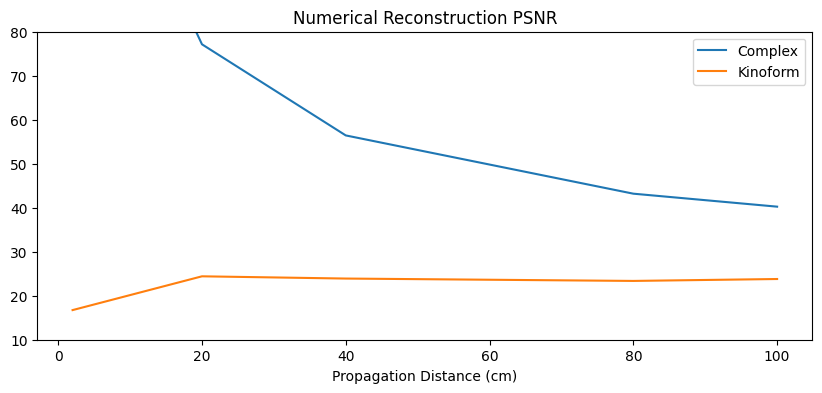

In [ ]:
psnrs = []

for image1, image2 in zip(slm_to_image_1, slm_to_image_2):
    psnrs.append([
        peak_signal_noise_ratio(source, image1),
        peak_signal_noise_ratio(source, image2),
    ])

plt.figure(figsize=(10, 4))
plt.plot([z * 100 for z in prop_dist], psnrs)
plt.legend(('Complex', 'Kinoform'))
plt.title('Numerical Reconstruction PSNR')
plt.ylim([10, 80])
plt.xlabel('Propagation Distance (cm)')
plt.show()

# 7. Discussion

# 8. 2D Image

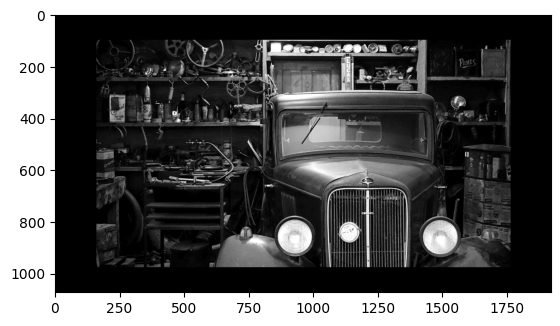

In [ ]:
import skimage.io as sio
img = sio.imread('sample1.png')[:, :, 1] / 255.
plt.imshow(img, cmap='gray')
plt.show()

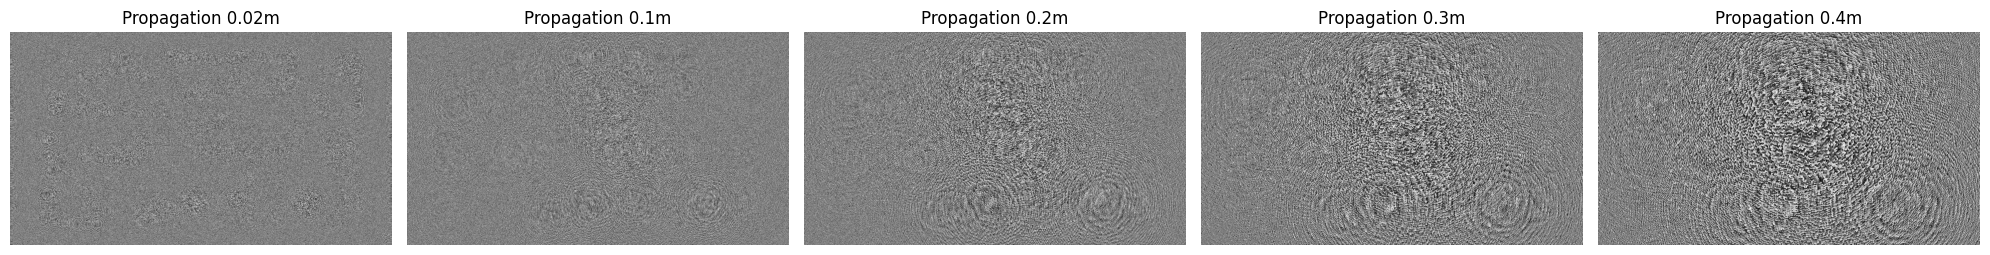

In [ ]:
# fixed
img = sio.imread('sample1.png')[:, :, 1] / 255.
img = img * np.exp(1j * np.zeros_like(img))
feature_size = (6.4 * um, 6.4 * um)

# experiment
wave_length = 633 * nm
prop_dist = [2 * cm, 10 * cm, 20 * cm, 30 * cm, 40 * cm]
visualization_title = [f'Propagation {z}m' for z in prop_dist]

kinoform_pohs = []
for z in prop_dist:
    kinoform_pohs.append(
        kinoform(img, feature_size, wave_length, z)
    )

plt.figure(figsize=(20, 20))
for i, kinoform_poh in enumerate(kinoform_pohs):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(kinoform_poh, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

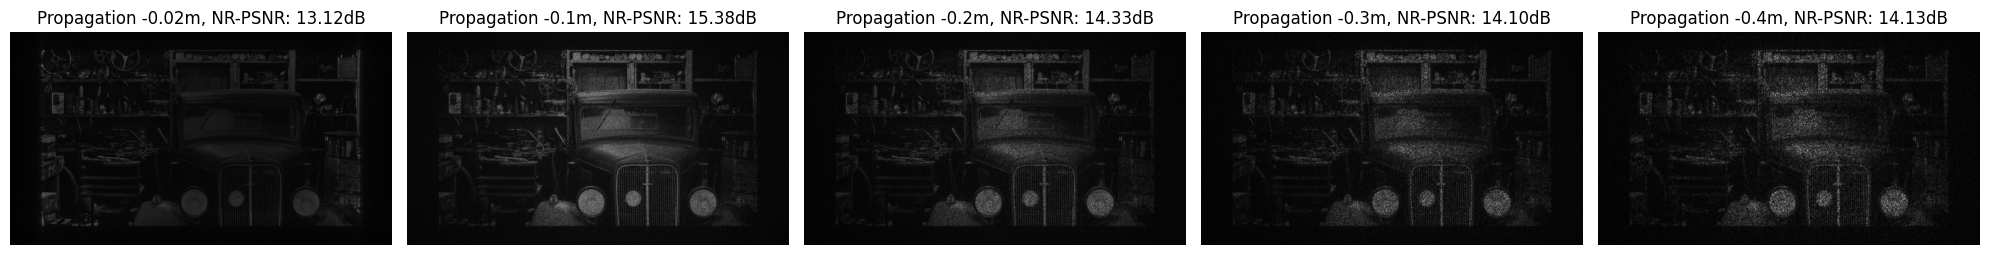

In [ ]:
img = np.abs(img)
psnrs = []
slm_to_image = []
for z, kinoform_poh in zip(prop_dist, kinoform_pohs):
    recon = propagation_blasm(np.exp(1j * kinoform_poh), feature_size, wave_length, -z)

    recon = np.abs(recon)
    recon = (recon - np.amin(recon)) / (np.amax(recon) - np.amin(recon))
    
    slm_to_image.append(recon)
    psnrs.append(peak_signal_noise_ratio(img, recon))

visualization_title = [f'Propagation -{z}m, NR-PSNR: {psnr:.2f}dB' for psnr, z in zip(psnrs, prop_dist)]

plt.figure(figsize=(20, 20))
for i, image in enumerate(slm_to_image):
    plt.subplot(1, len(prop_dist), i + 1)
    plt.imshow(image, cmap="gray")
    plt.title(visualization_title[i])
    plt.axis('off')
plt.tight_layout()
plt.show()